In [20]:
import time
import logging
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import download, viz

In [2]:
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.yolo import YOLO3DefaultTrainTransform
from gluoncv.data.dataloader import RandomTransformDataLoader
from gluoncv.utils import LRScheduler, LRSequential

In [3]:
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
gcv.utils.random.seed(233)

In [5]:
url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.rec'
idx_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.idx'
download(url, path='pikachu_train.rec', overwrite=False)
download(idx_url, path='pikachu_train.idx', overwrite=False)

'pikachu_train.idx'

label: [[309.6292  205.79944 355.75494 274.14044   0.     ]]
shape: (512, 512, 3)


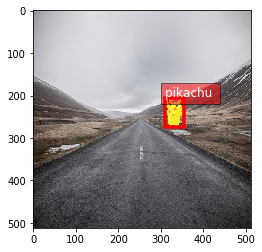

In [6]:
dataset = gcv.data.RecordFileDetection('pikachu_train.rec')
classes = ['pikachu']  # only one foreground class here
image, label = dataset[0]
print('label:', label)
print('shape:', image.shape)
# display image and label
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)

plt.show()

In [22]:
ctx = [mx.gpu(0), mx.gpu(1), mx.gpu(2), mx.gpu(3)]

net = gcv.model_zoo.get_model(
    'yolo3_darknet53_coco',
    pretrained=True,
)
net.reset_class(classes)

In [8]:
batch_size = 16

def get_dataloader(net, train_dataset, batch_size, num_workers):
    batchify_fn = Tuple(*([Stack() for _ in range(6)] + [Pad(axis=0, pad_val=-1) for _ in range(1)]))
    transform_fns = [YOLO3DefaultTrainTransform(x, x, net) for x in [320, 416, 512]]
    train_loader = RandomTransformDataLoader(
        transform_fns, train_dataset, batch_size=batch_size, interval=10, last_batch='rollover',
        shuffle=True, batchify_fn=batchify_fn, num_workers=num_workers
    )
    return train_loader

train_data = get_dataloader(net, dataset, batch_size, 4)

In [9]:
net.collect_params().reset_ctx(ctx)

trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'wd': 0.0005, 'momentum': 0.9, 'learning_rate': 0.0003},
    kvstore='local'
)

In [10]:
epochs = 15

# metrics
obj_metrics = mx.metric.Loss('ObjLoss')
center_metrics = mx.metric.Loss('BoxCenterLoss')
scale_metrics = mx.metric.Loss('BoxScaleLoss')
cls_metrics = mx.metric.Loss('ClassLoss')

for epoch in range(epochs):
    obj_metrics.reset()
    center_metrics.reset()
    scale_metrics.reset()
    cls_metrics.reset()
    
    tic = time.time()
    btic = time.time()
    mx.nd.waitall()
    net.hybridize(static_alloc=True)
    for i, batch in enumerate(train_data):
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        # objectness, center_targets, scale_targets, weights, class_targets
        fixed_targets = [gluon.utils.split_and_load(batch[it], ctx_list=ctx, batch_axis=0) for it in range(1, 6)]
        gt_boxes = gluon.utils.split_and_load(batch[6], ctx_list=ctx, batch_axis=0)
        sum_losses = []
        obj_losses = []
        center_losses = []
        scale_losses = []
        cls_losses = []    
        with autograd.record():
            for ix, x in enumerate(data):
                obj_loss, center_loss, scale_loss, cls_loss = net(x, gt_boxes[ix], *[ft[ix] for ft in fixed_targets])
                sum_losses.append(obj_loss + center_loss + scale_loss + cls_loss)
                obj_losses.append(obj_loss)
                center_losses.append(center_loss)
                scale_losses.append(scale_loss)
                cls_losses.append(cls_loss)
            autograd.backward(sum_losses)
        trainer.step(batch_size)

        obj_metrics.update(0, obj_losses)
        center_metrics.update(0, center_losses)
        scale_metrics.update(0, scale_losses)
        cls_metrics.update(0, cls_losses)
        if (i+1) % 20 == 0:
            name1, loss1 = obj_metrics.get()
            name2, loss2 = center_metrics.get()
            name3, loss3 = scale_metrics.get()
            name4, loss4 = cls_metrics.get()
            print('[Epoch {}][Batch {}], LR: {:.2E}, Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}'.format(
                  epoch, i, trainer.learning_rate, batch_size/(time.time()-btic), name1, loss1, name2, loss2, name3, loss3, name4, loss4))
        btic = time.time()
    
    name1, loss1 = obj_metrics.get()
    name2, loss2 = center_metrics.get()
    name3, loss3 = scale_metrics.get()
    name4, loss4 = cls_metrics.get()
    logger.info('[Epoch {}] Training cost: {:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}'.format(
        epoch, (time.time()-tic), name1, loss1, name2, loss2, name3, loss3, name4, loss4))

[Epoch 0][Batch 19], LR: 1.00E-04, Speed: 33.113 samples/sec, ObjLoss=358.106, BoxCenterLoss=2.815, BoxScaleLoss=1.359, ClassLoss=0.587
[Epoch 0][Batch 39], LR: 1.00E-04, Speed: 29.181 samples/sec, ObjLoss=182.838, BoxCenterLoss=2.790, BoxScaleLoss=1.182, ClassLoss=0.597


INFO:root:[Epoch 0] Training cost: 38.091, ObjLoss=131.654, BoxCenterLoss=2.771, BoxScaleLoss=1.062, ClassLoss=0.577


[Epoch 1][Batch 19], LR: 1.00E-04, Speed: 38.334 samples/sec, ObjLoss=3.160, BoxCenterLoss=2.731, BoxScaleLoss=0.637, ClassLoss=0.486
[Epoch 1][Batch 39], LR: 1.00E-04, Speed: 30.852 samples/sec, ObjLoss=3.115, BoxCenterLoss=2.705, BoxScaleLoss=0.648, ClassLoss=0.458


INFO:root:[Epoch 1] Training cost: 33.170, ObjLoss=2.960, BoxCenterLoss=2.687, BoxScaleLoss=0.636, ClassLoss=0.432


[Epoch 2][Batch 19], LR: 1.00E-04, Speed: 35.004 samples/sec, ObjLoss=2.477, BoxCenterLoss=2.619, BoxScaleLoss=0.567, ClassLoss=0.329
[Epoch 2][Batch 39], LR: 1.00E-04, Speed: 29.944 samples/sec, ObjLoss=2.361, BoxCenterLoss=2.606, BoxScaleLoss=0.527, ClassLoss=0.324


INFO:root:[Epoch 2] Training cost: 31.515, ObjLoss=2.432, BoxCenterLoss=2.598, BoxScaleLoss=0.533, ClassLoss=0.319


[Epoch 3][Batch 19], LR: 1.00E-04, Speed: 37.947 samples/sec, ObjLoss=2.157, BoxCenterLoss=2.563, BoxScaleLoss=0.514, ClassLoss=0.247
[Epoch 3][Batch 39], LR: 1.00E-04, Speed: 33.338 samples/sec, ObjLoss=2.139, BoxCenterLoss=2.541, BoxScaleLoss=0.512, ClassLoss=0.230


INFO:root:[Epoch 3] Training cost: 32.017, ObjLoss=2.143, BoxCenterLoss=2.541, BoxScaleLoss=0.505, ClassLoss=0.224


[Epoch 4][Batch 19], LR: 1.00E-04, Speed: 24.474 samples/sec, ObjLoss=1.874, BoxCenterLoss=2.497, BoxScaleLoss=0.475, ClassLoss=0.165
[Epoch 4][Batch 39], LR: 1.00E-04, Speed: 33.220 samples/sec, ObjLoss=1.870, BoxCenterLoss=2.476, BoxScaleLoss=0.467, ClassLoss=0.158


INFO:root:[Epoch 4] Training cost: 32.687, ObjLoss=1.857, BoxCenterLoss=2.470, BoxScaleLoss=0.468, ClassLoss=0.151


[Epoch 5][Batch 19], LR: 1.00E-04, Speed: 26.897 samples/sec, ObjLoss=1.614, BoxCenterLoss=2.411, BoxScaleLoss=0.420, ClassLoss=0.117
[Epoch 5][Batch 39], LR: 1.00E-04, Speed: 28.384 samples/sec, ObjLoss=1.696, BoxCenterLoss=2.397, BoxScaleLoss=0.432, ClassLoss=0.117


INFO:root:[Epoch 5] Training cost: 31.379, ObjLoss=1.670, BoxCenterLoss=2.400, BoxScaleLoss=0.424, ClassLoss=0.110


[Epoch 6][Batch 19], LR: 1.00E-04, Speed: 31.188 samples/sec, ObjLoss=1.638, BoxCenterLoss=2.354, BoxScaleLoss=0.488, ClassLoss=0.099
[Epoch 6][Batch 39], LR: 1.00E-04, Speed: 29.474 samples/sec, ObjLoss=1.624, BoxCenterLoss=2.367, BoxScaleLoss=0.474, ClassLoss=0.103


INFO:root:[Epoch 6] Training cost: 31.164, ObjLoss=1.599, BoxCenterLoss=2.363, BoxScaleLoss=0.469, ClassLoss=0.099


[Epoch 7][Batch 19], LR: 1.00E-04, Speed: 28.712 samples/sec, ObjLoss=1.360, BoxCenterLoss=2.331, BoxScaleLoss=0.438, ClassLoss=0.072
[Epoch 7][Batch 39], LR: 1.00E-04, Speed: 30.251 samples/sec, ObjLoss=1.582, BoxCenterLoss=2.354, BoxScaleLoss=0.451, ClassLoss=0.092


INFO:root:[Epoch 7] Training cost: 32.144, ObjLoss=1.619, BoxCenterLoss=2.352, BoxScaleLoss=0.452, ClassLoss=0.096


[Epoch 8][Batch 19], LR: 1.00E-04, Speed: 33.217 samples/sec, ObjLoss=1.398, BoxCenterLoss=2.314, BoxScaleLoss=0.454, ClassLoss=0.073
[Epoch 8][Batch 39], LR: 1.00E-04, Speed: 31.257 samples/sec, ObjLoss=1.515, BoxCenterLoss=2.349, BoxScaleLoss=0.443, ClassLoss=0.089


INFO:root:[Epoch 8] Training cost: 32.052, ObjLoss=1.496, BoxCenterLoss=2.350, BoxScaleLoss=0.442, ClassLoss=0.081


[Epoch 9][Batch 19], LR: 1.00E-04, Speed: 25.011 samples/sec, ObjLoss=1.528, BoxCenterLoss=2.279, BoxScaleLoss=0.470, ClassLoss=0.061
[Epoch 9][Batch 39], LR: 1.00E-04, Speed: 35.355 samples/sec, ObjLoss=1.472, BoxCenterLoss=2.287, BoxScaleLoss=0.461, ClassLoss=0.066


INFO:root:[Epoch 9] Training cost: 31.703, ObjLoss=1.427, BoxCenterLoss=2.278, BoxScaleLoss=0.447, ClassLoss=0.061


[Epoch 10][Batch 19], LR: 1.00E-04, Speed: 29.699 samples/sec, ObjLoss=1.479, BoxCenterLoss=2.268, BoxScaleLoss=0.430, ClassLoss=0.065
[Epoch 10][Batch 39], LR: 1.00E-04, Speed: 30.597 samples/sec, ObjLoss=1.410, BoxCenterLoss=2.267, BoxScaleLoss=0.448, ClassLoss=0.058


INFO:root:[Epoch 10] Training cost: 31.829, ObjLoss=1.324, BoxCenterLoss=2.267, BoxScaleLoss=0.437, ClassLoss=0.055


[Epoch 11][Batch 19], LR: 1.00E-04, Speed: 33.658 samples/sec, ObjLoss=1.348, BoxCenterLoss=2.271, BoxScaleLoss=0.473, ClassLoss=0.043
[Epoch 11][Batch 39], LR: 1.00E-04, Speed: 30.390 samples/sec, ObjLoss=1.340, BoxCenterLoss=2.252, BoxScaleLoss=0.437, ClassLoss=0.047


INFO:root:[Epoch 11] Training cost: 32.495, ObjLoss=1.309, BoxCenterLoss=2.252, BoxScaleLoss=0.427, ClassLoss=0.046


[Epoch 12][Batch 19], LR: 1.00E-04, Speed: 33.279 samples/sec, ObjLoss=1.179, BoxCenterLoss=2.281, BoxScaleLoss=0.446, ClassLoss=0.047
[Epoch 12][Batch 39], LR: 1.00E-04, Speed: 26.822 samples/sec, ObjLoss=1.210, BoxCenterLoss=2.270, BoxScaleLoss=0.454, ClassLoss=0.044


INFO:root:[Epoch 12] Training cost: 32.118, ObjLoss=1.259, BoxCenterLoss=2.278, BoxScaleLoss=0.451, ClassLoss=0.049


[Epoch 13][Batch 19], LR: 1.00E-04, Speed: 26.511 samples/sec, ObjLoss=1.458, BoxCenterLoss=2.255, BoxScaleLoss=0.417, ClassLoss=0.057
[Epoch 13][Batch 39], LR: 1.00E-04, Speed: 30.089 samples/sec, ObjLoss=1.305, BoxCenterLoss=2.256, BoxScaleLoss=0.421, ClassLoss=0.049


INFO:root:[Epoch 13] Training cost: 31.580, ObjLoss=1.338, BoxCenterLoss=2.258, BoxScaleLoss=0.415, ClassLoss=0.050


[Epoch 14][Batch 19], LR: 1.00E-04, Speed: 35.714 samples/sec, ObjLoss=1.149, BoxCenterLoss=2.251, BoxScaleLoss=0.389, ClassLoss=0.045
[Epoch 14][Batch 39], LR: 1.00E-04, Speed: 37.188 samples/sec, ObjLoss=1.161, BoxCenterLoss=2.221, BoxScaleLoss=0.375, ClassLoss=0.043


INFO:root:[Epoch 14] Training cost: 31.470, ObjLoss=1.139, BoxCenterLoss=2.227, BoxScaleLoss=0.383, ClassLoss=0.042


In [11]:
net.save_parameters('yolo3.pikachu.params')

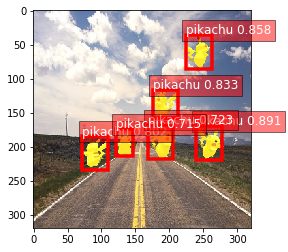

In [74]:
test_url = 'https://raw.githubusercontent.com/zackchase/mxnet-the-straight-dope/master/img/pikachu.jpg'
download(test_url, 'pikachu_test.jpg')
finetune_net = gcv.model_zoo.get_model(
    'yolo3_darknet53_custom',
    classes=classes,
    pretrained_base=False,
)
finetune_net.load_parameters('yolo3.pikachu.params')
x, image = gcv.data.transforms.presets.yolo.load_test('pikachu_test.jpg', short=320)
cid, score, bbox = finetune_net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes, thresh=.5)

plt.show()

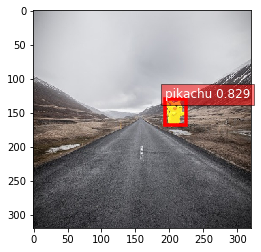

In [70]:
x = dataset[0][0]
x, image = gcv.data.transforms.presets.yolo.transform_test(x, short=320)
cid, score, bbox = finetune_net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes, thresh=.4)

plt.show()